In [29]:
import copy
import glob
import json
import os
import random
import re
from collections import Counter
from random import shuffle

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import fastparquet
import numpy as np
from matplotlib import pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
dataset_folder='./../dataset/saved/'

In [30]:
random.seed(0)

In [31]:
root_dir = "/home/kirill/Documents/1.Projects/class-ranking/project-processing-results/processing/java/classes/processing/0.0.2/intellij-community/"

cnt = 0
individualUsages = {}  # {className -> {className -> count}}
graph = {}  #{className -> [parentNames]}

def good(usage) -> bool:
    # {'TYPE', 'THIS_EXPRESSION', 'EXTENDS_LIST', 'IMPLEMENTS_LIST', 'METHOD_REF_EXPRESSION', 'EXPRESSION_LIST', 'NEW_EXPRESSION', 'CONDITIONAL_EXPRESSION', 'FIELD', 'ANNOTATION', 'THROWS_LIST', 'SUPER_EXPRESSION', 'JAVA_CODE_REFERENCE', 'REFERENCE_EXPRESSION', 'DOC_REFERENCE_HOLDER'}
    if usage["features"]["referenceType"] == "ANNOTATION":
        return False
    if usage["features"]["referenceType"] == "DOC_REFERENCE_HOLDER":
        return False
    return True

def addToUsages(data, individualUsages):
    enclosingName = data["keyInfo"]["name"]
    c = Counter()
    for usage in data['usages']:
        if good(usage):
            c.update([usage['name']])
    individualUsages[enclosingName] = c

def addToGraph(data, graph):
    enclosingName = data["keyInfo"]["name"]
    extends = data["keyInfo"]["additionalInfo"]["enclosingClassExtendsList"]
    impls = data["keyInfo"]["additionalInfo"]["enclosingClassImplementsList"]
    if enclosingName not in graph:
        graph[enclosingName] = set()
    for par in (extends + impls):
        if par not in graph:
            graph[par] = set()
        graph[par].update({enclosingName})


print(f'load files, build a graph, count indevidual usages ')
for filename in glob.glob(root_dir + '**/*.json', recursive=True):
    with open(os.path.join(os.getcwd(), filename), 'r') as f:
        data = json.load(f)
        addToUsages(data, individualUsages)
        addToGraph(data, graph)
        cnt += 1
        if cnt % 10**4 == 0:
            print(f'{cnt} files loaded, for current file: direct_usages = {len(individualUsages[data["keyInfo"]["name"]])} | direct_children = {len(graph[data["keyInfo"]["name"]])} ')
print(f'{cnt} files processed ')

load files, build a graph, count indevidual usages 
10000 files loaded, for current file: direct_usages = 13 | direct_children = 0 
20000 files loaded, for current file: direct_usages = 0 | direct_children = 4 
30000 files loaded, for current file: direct_usages = 20 | direct_children = 0 
40000 files loaded, for current file: direct_usages = 7 | direct_children = 0 
50000 files loaded, for current file: direct_usages = 8 | direct_children = 0 
60000 files loaded, for current file: direct_usages = 2 | direct_children = 0 
61469 files processed 


In [32]:
familyUsages = {} # className -> usages in all children (className -> number)
family = {} # className -> self and all children set(className)
parent = {} # className -> className
def dfs(v):
    cur_usages = copy.deepcopy(individualUsages[v])
    cur_family_set = {v}
    for u in graph[v]:
        if u not in family:
            parent[u] = v
            dfs(u)

        u_usages, u_child_set = familyUsages[u], family[u]
        cur_usages.update(u_usages)
        cur_family_set.update(u_child_set)
    familyUsages[v], family[v] = cur_usages, cur_family_set


v_count = 0
for v in individualUsages:
    if v not in familyUsages:
        dfs(v)
    v_count += 1
    if v_count % 10**4 == 0:
        print(f'{v_count} vertexes evalueted | in {v} used {len(familyUsages[v])} classes, {len(family[v])} children')

10000 vertexes evalueted | in org.intellij.lang.regexp.surroundWith.SimpleSurroundDescriptor used 13 classes, 1 children
20000 vertexes evalueted | in com.intellij.ide.presentation.PresentationProvider used 44 classes, 19 children
30000 vertexes evalueted | in com.jetbrains.python.codeInsight.editorActions.smartEnter.fixers.PyMatchStatementFixer used 20 classes, 1 children
40000 vertexes evalueted | in com.android.tools.idea.gradle.run.AndroidGradleTestTasksProvider used 7 classes, 1 children
50000 vertexes evalueted | in com.intellij.refactoring.extractMethod.preview.PreviewPanel.ButtonsPanel used 8 classes, 1 children
60000 vertexes evalueted | in org.jetbrains.android.dom.drawable.AnimationList used 2 classes, 1 children


In [33]:
#ROOT_CLASS = "com.intellij.openapi.project.DumbAware"
ROOT_CLASS = "com.intellij.openapi.actionSystem.AnAction"
#print(familyUsages[ROOT_CLASS].most_common())

In [34]:
train_test_classes = family[ROOT_CLASS]
train_list, test_list = train_test_split(list(train_test_classes), train_size=0.7, random_state=0)
test_list, valid_list = train_test_split(test_list, train_size=0.65, random_state=0)
trainClasses = set(train_list)
testClasses = set(test_list)
validClasses = set(valid_list)

In [35]:
train_usages = set()
for c in trainClasses:
    train_usages.update(individualUsages[c].keys())

In [36]:
firstCharToNameList = {}
for k, v in familyUsages[ROOT_CLASS].most_common():
    if k not in train_usages:
        continue
    first_char = k.rpartition('.')[2][0]
    if first_char not in firstCharToNameList:
        firstCharToNameList[first_char] = []
    firstCharToNameList[first_char].append(k)

with open(dataset_folder+'FirstCharToNameList.txt', 'w') as convert_file:
     convert_file.write(json.dumps(firstCharToNameList))

# for k in firstCharToNameList:
#     print(f'{k} {len(firstCharToNameList[k])}')

In [37]:
firstCharToNameListSampling = {}
for k, v in familyUsages[ROOT_CLASS].most_common():
    if k not in train_usages:
        continue
    first_char = k.rpartition('.')[2][0]
    if first_char not in firstCharToNameListSampling:
        firstCharToNameListSampling[first_char] = []
    firstCharToNameListSampling[first_char] += [k] * v

for k in firstCharToNameListSampling:
    shuffle(firstCharToNameListSampling[k])

with open(dataset_folder+'FirstCharToNameListSampling.txt', 'w') as convert_file:
     convert_file.write(json.dumps(firstCharToNameListSampling))

In [38]:
def listToStr(df, col):
    tmp = df[col].isnull(), col
    df.loc[tmp] = df.loc[tmp].apply(lambda x: [])
    df[col] = df[col].apply(lambda x: " ".join(x) )

In [39]:


cnt = 0
cntu = 0
list_of_dfs_train = []
list_of_dfs_test = []
list_of_dfs_valid = []
group_id = 0
for filename in glob.glob(root_dir + '**/*.json', recursive=True):
    enclosingClassName = filename.rpartition('/')[0].rpartition('/')[2]
    if enclosingClassName not in train_test_classes:
            continue
    with open(os.path.join(os.getcwd(), filename), 'r') as f:
        data = json.load(f)
        data_usages = []
        # if enclosingClassName in validClasses:
        #     with open("paths.txt", 'a') as log:
        #         log.write(f'\"{data["usages"][0]["filePath"]}\",\n')
        for usage in data["usages"]:
            if not good(usage):
                continue
            usage['correct'] = 1
            usage['firstChar'] = usage['name'].rpartition('.')[2][0]
            usage['group'] = group_id
            group_id += 1
            data_usages.append(usage)

            if enclosingClassName in trainClasses:
                negatives = 8
            else:
                negatives = 25

            for i in range(negatives):
                usage_negative = copy.deepcopy(usage)
                while True:
                    new_name = random.choice(firstCharToNameListSampling[usage['firstChar']]) #?
                    if usage['name'] != new_name:
                        usage_negative['name'] = new_name
                        usage_negative['correct'] = 0
                        break
                data_usages.append(usage_negative)

        if len(data_usages) == 0:
            continue
        df = pd.json_normalize(data_usages)
        df['features.enclosingClassName'] = enclosingClassName

        # print(enclosingClassName)
        # if enclosingClassName == 'com.intellij.openapi.project.DumbAware' :
        #     print(df.dtypes)
        df = df.drop(columns=['filePath', 'textOffset', 'features.lineInFile'])
        if enclosingClassName in trainClasses:
            list_of_dfs_train.append(df)
        if enclosingClassName in testClasses:
            list_of_dfs_test.append(df)
        if enclosingClassName in validClasses:
            list_of_dfs_valid.append(df)
        cntu += len(data_usages)
        cnt += 1

df_train_raw = pd.concat(list_of_dfs_train, axis=0, ignore_index=True)
df_test_raw = pd.concat(list_of_dfs_test, axis=0, ignore_index=True)
df_valid_raw = pd.concat(list_of_dfs_valid, axis=0, ignore_index=True)

listToStr(df_train_raw, 'features.variablesTypesInScope')
listToStr(df_test_raw, 'features.variablesTypesInScope')
listToStr(df_valid_raw, 'features.variablesTypesInScope')
df_train_raw.fillna('', inplace=True)
df_test_raw.fillna('', inplace=True)
df_valid_raw.fillna('', inplace=True)

print(f'{cnt} files loaded, {cntu} usages')

print(f'test shape {df_test_raw.shape}')
print(f'train shape {df_train_raw.shape}')
print(f'valid shape {df_valid_raw.shape}')
df_train_raw.dtypes

# will we know referenceType irl ?

3030 files loaded, 657799 usages
test shape (240110, 12)
train shape (299961, 12)
valid shape (117728, 12)


name                              object
correct                            int64
firstChar                         object
group                              int64
features.referenceType            object
features.scopeKind                object
features.enclosingScopeName       object
features.enclosingClassName       object
features.variablesTypesInScope    object
features.insideStatement_0        object
features.insideStatement_1        object
features.insideStatement_2        object
dtype: object

In [40]:
df_train_raw.to_csv(dataset_folder+'train_raw.csv')
df_test_raw.to_csv(dataset_folder+'test_raw.csv')
df_valid_raw.to_csv(dataset_folder+'valid_raw.csv')

In [41]:
def splitCamelCase(name: str):
    res = []
    for rname in name.split(' '):
        rname = rname.strip('.')
        if '.' in rname:
            rname = rname.rpartition('.')[2]
        res += re.sub('([A-Z][a-z]+)', r' \1', re.sub('([A-Z]+)', r' \1', rname)).split()
        #res += [rname]
    return res

In [42]:
def str_to_OHE_feature(df_train, df_test, df_valid, col, pref, max_features=85, replace_columns=True):
    vectorizer_train = CountVectorizer(tokenizer=splitCamelCase, lowercase=False, max_features=max_features)
    term_doc_matrix_train = vectorizer_train.fit_transform(df_train[col].values.astype('str'))

    vectorizer_test_valid = CountVectorizer(tokenizer=splitCamelCase, lowercase=False, vocabulary=vectorizer_train.vocabulary_)
    term_doc_matrix_test = vectorizer_test_valid.fit_transform(df_test[col].values.astype('str'))
    term_doc_matrix_valid = vectorizer_test_valid.fit_transform(df_valid[col].values.astype('str'))

    df_train_bow = pd.DataFrame(term_doc_matrix_train.toarray(), columns=vectorizer_train.get_feature_names_out())
    df_test_bow = pd.DataFrame(term_doc_matrix_test.toarray(), columns=vectorizer_test_valid.get_feature_names_out())
    df_valid_bow = pd.DataFrame(term_doc_matrix_valid.toarray(), columns=vectorizer_test_valid.get_feature_names_out())

    df_train_bow = df_train_bow.astype(pd.SparseDtype(int, fill_value=0))
    df_test_bow = df_test_bow.astype(pd.SparseDtype(int, fill_value=0))
    df_valid_bow = df_valid_bow.astype(pd.SparseDtype(int, fill_value=0))

    # df_train_bow = pd.DataFrame()
    # for i, col in enumerate(vectorizer_train.get_feature_names_out()):
    #     df_train_bow[col] = pd.SparseSeries(term_doc_matrix_train[:, i].toarray().ravel(), fill_value=0)
    #
    # df_test_bow = pd.DataFrame()
    # for i, col in enumerate(vectorizer_test_valid.get_feature_names_out()):
    #     df_test_bow[col] = pd.SparseSeries(term_doc_matrix_test[:, i].toarray().ravel(), fill_value=0)
    #
    # df_valid_bow = pd.DataFrame()
    # for i, col in enumerate(vectorizer_test_valid.get_feature_names_out()):
    #     df_valid_bow[col] = pd.SparseSeries(term_doc_matrix_test[:, i].toarray().ravel(), fill_value=0)


    df_train_bow = df_train_bow.add_prefix(pref)
    df_test_bow = df_test_bow.add_prefix(pref)
    df_valid_bow = df_valid_bow.add_prefix(pref)

    df_train = pd.concat([df_train, df_train_bow], axis=1)
    df_test = pd.concat([df_test, df_test_bow], axis=1)
    df_valid = pd.concat([df_valid, df_valid_bow], axis=1)

    if replace_columns:
        df_train = df_train.drop(columns=[col])
        df_test = df_test.drop(columns=[col])
        df_valid = df_valid.drop(columns=[col])

    return df_train, df_test, df_valid

In [43]:
df_valid_raw = pd.read_csv(dataset_folder+'valid_eval_raw.csv').drop(columns=['Unnamed: 0'])

/tmp/ipykernel_40310/1605277727.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_valid_raw = pd.read_csv(dataset_folder+'valid_eval_raw.csv').drop(columns=['Unnamed: 0'])


In [44]:
df_valid_raw.dtypes

name                              object
correct                            int64
firstChar                         object
group                              int64
features.referenceType            object
features.scopeKind                object
features.enclosingScopeName       object
features.variablesTypesInScope    object
features.insideStatement_0        object
features.insideStatement_1        object
features.insideStatement_2        object
features.enclosingClassName       object
dtype: object

In [45]:


df_train, df_test, df_valid = df_train_raw, df_test_raw, df_valid_raw
print(f'train0 ########## ------> :\n {df_train.loc[[10]]}')
print(f'test0  ########## ------> :\n {df_test.loc[[10]]}')
print(f'valid0  ########## ------> :\n {df_valid.loc[[10]]}')
df_train, df_test, df_valid = str_to_OHE_feature(df_train, df_test, df_valid, 'name', pref='name_', replace_columns=False)
df_train, df_test, df_valid = str_to_OHE_feature(df_train, df_test, df_valid, 'features.enclosingScopeName', pref='enclosingScopeName_')
df_train, df_test, df_valid = str_to_OHE_feature(df_train, df_test, df_valid, 'features.enclosingClassName', pref='enclosingClassName_')
df_train, df_test, df_valid = str_to_OHE_feature(df_train, df_test, df_valid, 'features.variablesTypesInScope', pref='variablesTypesInScope_')
df_train, df_test, df_valid = str_to_OHE_feature(df_train, df_test, df_valid, 'features.referenceType', pref='referenceType_') # ?????????????????????????????????????????????????/
df_train, df_test, df_valid = str_to_OHE_feature(df_train, df_test, df_valid, 'features.scopeKind', pref='scopeKind_')
df_train, df_test, df_valid = str_to_OHE_feature(df_train, df_test, df_valid, 'features.insideStatement_0', pref='insideStatement0_')
df_train, df_test, df_valid = str_to_OHE_feature(df_train, df_test, df_valid, 'features.insideStatement_1', pref='insideStatement1_')
df_train, df_test, df_valid = str_to_OHE_feature(df_train, df_test, df_valid, 'features.insideStatement_2', pref='insideStatement2_')


#firstChar,features.referenceType,features.scopeKind,features.insideStatement_0,features.insideStatement_1,features.insideStatement_2

print(f'train1 ########## ------> :\n {df_train.loc[[10]]}')
print(f'test1  ########## ------> :\n {df_test.loc[[10]]}')
print(f'valid1  ########## ------> :\n {df_valid.loc[[10]]}')


train0 ########## ------> :
                                           name  correct firstChar  group  \
10  com.intellij.openapi.actionSystem.AnAction        0         A     25   

   features.referenceType features.scopeKind features.enclosingScopeName  \
10                   TYPE             Method             actionPerformed   

                          features.enclosingClassName  \
10  com.intellij.ide.palette.impl.PaletteWindow.Cl...   

   features.variablesTypesInScope features.insideStatement_0  \
10                                                             

   features.insideStatement_1 features.insideStatement_2  
10                                                        
test0  ########## ------> :
                                         name  correct firstChar  group  \
10  com.intellij.ide.util.treeView.TreeState        0         T     26   

   features.referenceType features.scopeKind features.enclosingScopeName  \
10           EXTENDS_LIST                        

In [46]:
df_train.to_pickle(dataset_folder+'train_ohe401')
df_test.to_pickle(dataset_folder+'test_ohe401')
df_valid.to_pickle(dataset_folder+'valid_ohe401')

In [47]:
print(f'train ########## ------> : {df_train.shape}')
print(f'test ########## ------> : {df_test.shape}')
print(f'valid ########## ------> : {df_valid.shape}')

train ########## ------> : (299961, 402)
test ########## ------> : (240110, 402)
valid ########## ------> : (134354, 402)


In [48]:
# s_tr = df_train.drop(columns=['name', 'firstChar', 'group', 'correct']).sum().div(df_train.shape[0]).mul(100)
s_tr = df_valid.drop(columns=['name', 'firstChar', 'group', 'correct']).sum().div(df_valid.shape[0]).mul(100)

In [49]:
s_tr.sort_values(ascending=[False]).sum() / df_valid.shape[1]

2.5331183077126687

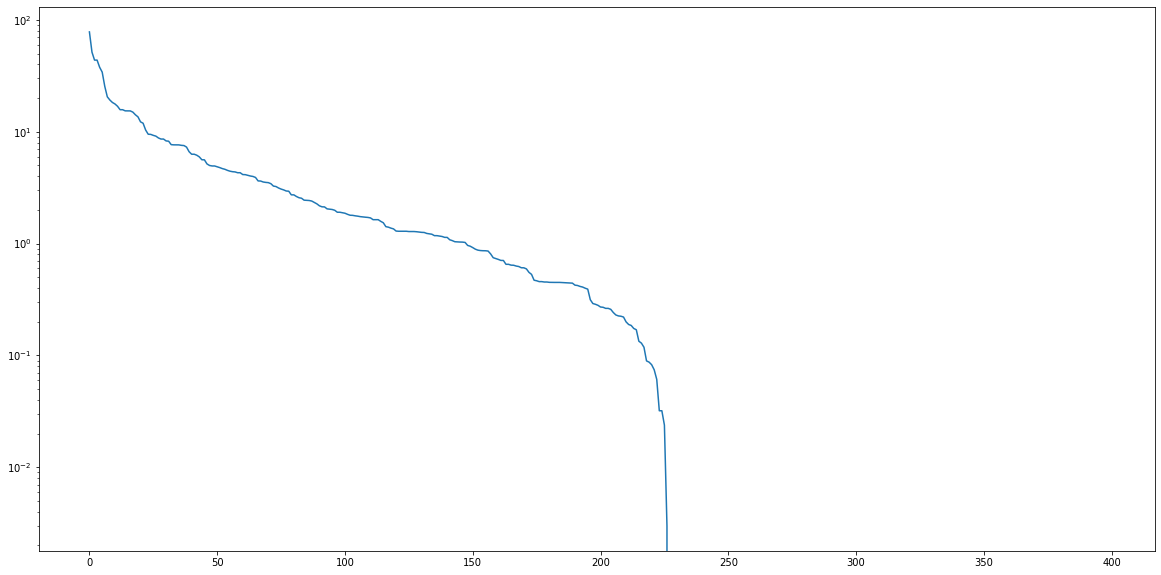

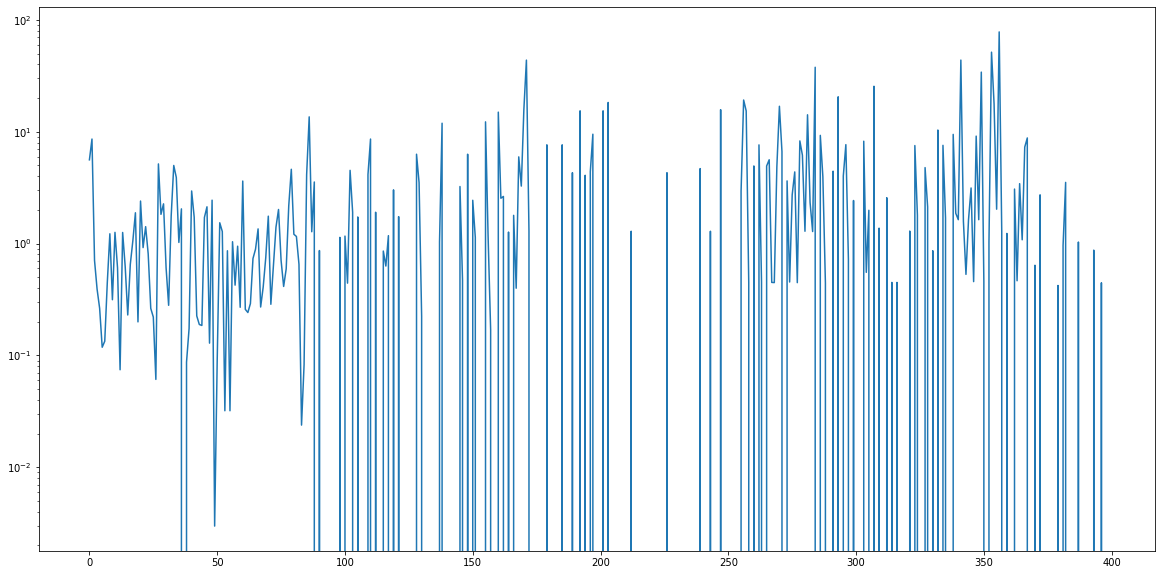

In [50]:
plt.figure(figsize=(20, 10))
plt.plot(np.arange(s_tr.shape[0]), s_tr.sort_values(ascending=[False]).to_list())
plt.yscale('log')
plt.show()

plt.figure(figsize=(20, 10))
plt.plot(np.arange(s_tr.shape[0]), s_tr.to_list())
plt.yscale('log')
plt.show()

In [51]:
df_valid.columns

Index(['name', 'correct', 'firstChar', 'group', 'name_Abstract', 'name_Action',
       'name_Actions', 'name_All', 'name_An', 'name_Android',
       ...
       'insideStatement1_while_body', 'insideStatement2_for_body',
       'insideStatement2_foreach_body', 'insideStatement2_if_condition',
       'insideStatement2_if_else_body', 'insideStatement2_if_then_body',
       'insideStatement2_return', 'insideStatement2_ternary_else',
       'insideStatement2_try', 'insideStatement2_while_body'],
      dtype='object', length=402)